In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import *
from Network import *
from tqdm.autonotebook import tqdm

In [2]:
selected_num = 1

data_path = "./Refined_Data/Grouped_Data/Input_Data1.csv"
data = pd.read_csv(data_path, parse_dates = ["date_time"])

In [3]:
# model configuration

enc_seq_len = 14

dim_val = 128
dim_attn = 32
lr = 0.001
epochs = 30

n_heads = 4

n_encoder_layers = 6

warmup_steps = 4000

use_cuda = True

In [4]:
data = data.loc[data["num"] == selected_num]

# all_len = 2040
valid_len = 168
train_len = 2040 - 168

In [5]:
input_data = data[['C', 'm/s', 'wet', 'mm', 'hr',
                    'non_electric_aircondition', 'sunlight',
                    'day_of_Week', 'day_of_month', '24Hour', 'holiday',
                    'Weekend', 'hour_cat', 'discomfort_index']] # 14

# input_data = data[['C', 'm/s', 'wet', 'mm', 'hr',
#                     'non_electric_aircondition', 'sunlight', 'time_idx', 'energy_group',
#                     'Week', 'day_of_Week', 'day_of_month', 'day', '24Hour', 'holiday',
#                     'Weekend', 'hour_cat', 'discomfort_index']] # 18

output_data = data[['kWH']]

print(data.columns)
print(len(output_data))

Index(['Unnamed: 0', 'num', 'date_time', 'kWH', 'C', 'm/s', 'wet', 'mm', 'hr',
       'non_electric_aircondition', 'sunlight', 'time_idx', 'energy_group',
       'Week', 'day_of_Week', 'day_of_month', 'day', '24Hour', 'holiday',
       'Weekend', 'hour_cat', 'discomfort_index'],
      dtype='object')
2040


In [6]:
train_input = input_data[:train_len]
train_output = output_data[:train_len]

valid_input = input_data[-valid_len:]
valid_output = output_data[-valid_len:]

print(len(train_input))
print(len(valid_input))

1872
168


In [7]:
# model prepare

model = Transformer_encoder_nn(dim_val, dim_attn, enc_seq_len, 1,          n_encoder_layers,     n_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if use_cuda:
    model = model.cuda()

#keep track of loss for graph
losses = []

def lr_scheduler(d_model, step_num, warmup_steps = warmup_steps):
    lr = (d_model**-0.5) * min((step_num**-0.5), step_num * (warmup_steps**-1.5))
    return lr

def smape(y_pred, target):
    return 2 * (y_pred - target).abs() / (y_pred.abs() + target.abs() + 1e-8)

In [8]:
step_num = 0
    
for e in range(epochs):
    # train
    
    out = []

    progress_bar = tqdm(range(len(train_input)))

    for t in progress_bar:

        step_num += 1
        optimizer.param_groups[0]['lr'] = lr_scheduler(dim_val, step_num)

        optimizer.zero_grad()
        X = torch.tensor(train_input.iloc[t].tolist()).reshape(1, enc_seq_len, 1)
        Y = torch.tensor(train_output.iloc[t].tolist()).reshape(1,1)

        if use_cuda:
            X = X.cuda()
            Y = Y.cuda()

        net_out = model(X)
        loss = smape(net_out, Y)

        loss.backward()
        optimizer.step()

        out.append([net_out.cpu().detach().numpy(), Y])
        losses.append(loss.cpu().detach().numpy())

        progress_bar.set_description(f"epoch : {e}/{epochs} loss : {loss.cpu().detach().numpy()} learning rate : {round(optimizer.param_groups[0]['lr'],10)}")

    
    # validation

    model.eval()

    progress_bar_eval = tqdm(range(len(valid_input)))
    eval_loss = []

    for v in progress_bar_eval:
        with torch.no_grad():
            X = torch.tensor(valid_input.iloc[v].tolist()).reshape(1, enc_seq_len, 1)
            Y = torch.tensor(valid_output.iloc[v].tolist()).reshape(1,1)

            if use_cuda:
                X = X.cuda()
                Y = Y.cuda()

            net_out = model(X)
            loss = smape(net_out, Y)
            eval_loss.append(loss.cpu().detach().numpy()[0][0])

            progress_bar_eval.set_description(f"epoch : {e}/{epochs} loss : {loss.cpu().detach().numpy()[0][0]}")

    print(f"\nvalidation loss : {np.mean(np.array(eval_loss))}\n")

    model.train()

epoch : 0/200 loss : [[0.01008055]] learning rate : 0.0006540499: 100%|██████████| 1872/1872 [01:32<00:00, 20.30it/s]
epoch : 0/200 loss : 0.006153326015919447: 100%|██████████| 168/168 [00:01<00:00, 93.82it/s]
validation loss : 0.013960229232907295




[ 0.0000],
         [ 6.0000],
         [22.0000],
         [13.0000],
         [ 0.0000],
         [ 1.0000],
         [ 3.0000],
         [ 1.0000]]], device='cuda:0')
tensor([[8758.9111]], device='cuda:0')
tensor([[[25.0000],
         [ 1.9000],
         [89.0000],
         [ 0.7000],
         [ 0.1000],
         [ 0.0000],
         [ 0.0000],
         [ 6.0000],
         [22.0000],
         [14.0000],
         [ 0.0000],
         [ 1.0000],
         [ 4.0000],
         [ 2.0000]]], device='cuda:0')
tensor([[8758.9111]], device='cuda:0')
tensor([[[23.5000],
         [ 3.3000],
         [89.0000],
         [ 2.7000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 6.0000],
         [22.0000],
         [15.0000],
         [ 0.0000],
         [ 1.0000],
         [ 4.0000],
         [ 1.0000]]], device='cuda:0')
tensor([[8758.9111]], device='cuda:0')
tensor([[[23.2000],
         [ 2.1000],
         [93.0000],
         [ 5.1000],
         [ 0.0000],
         [ 0.00

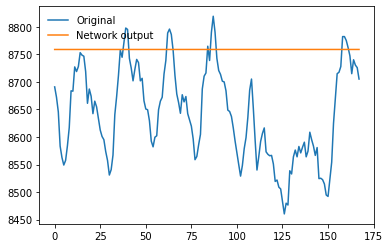

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

# predict visualization

fig = plt.figure()
ax = fig.add_subplot(111)

original = valid_output['kWH'].to_list()
output = []

model.eval()
for v in range(len(valid_input)):
    with torch.no_grad():
        X = torch.tensor(valid_input.iloc[v].tolist()).reshape(1, enc_seq_len, 1)
        Y = torch.tensor(valid_output.iloc[v].tolist()).reshape(1,1)

        if use_cuda:
            X = X.cuda()
            Y = Y.cuda()

        net_out = model(X)

        output.append(net_out.cpu().detach().squeeze().numpy().tolist())

ax.clear()
ax.plot(original, label='Original')
ax.plot(output, label='Network output')
ax.set_title("")
ax.legend(loc='upper left', frameon=False)

fig.show()